# Imports

In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
#import skorch
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
#from cont_metrics.density_estimation.pytorch_kde import kde
#from cont_metrics.hgr import hgr_cond
#from cont_metrics.hgr import hgr
import aif360 as aif

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
from fairness.helpers import *

#from fairlearn.postprocessing import ThresholdOptimizer
#from fairlearn.postprocessing import plot_threshold_optimizer

from fairness.avd_helpers import *

#from aif360.algorithms.postprocessing import *
import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
#from comet_ml import Experiment
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

pip install 'aif360[LawSchoolGPA]'
2023-02-09 12:07:47.260143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Load Data

In [4]:
df = pd.read_csv('../../data/compas/compas-scores-two-years.csv')

In [6]:
dd = df[['sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count', 'score_text', 'c_charge_degree', 'two_year_recid', 'is_recid', 'days_b_screening_arrest',
        'juv_fel_count', 'juv_misd_count']].replace({
    'Greater than 45':'Above_FourtyFive',
    'Less than 25':'Below_TwentyFive',
    '25 - 45': 'Between_25_45',
    'M':'Misdemeanor',
    'F':'Felony'
})

dd = dd[(dd.days_b_screening_arrest <= 30) & (dd.days_b_screening_arrest >=-30)]\
        .drop(columns=['days_b_screening_arrest','is_recid', 'two_year_recid', 'age_cat'])\
        .assign(score_factor = lambda x: x['score_text'].map(lambda y: 1 if y=='Low' else 0))
dd = dd[(dd.race=='African-American') | (dd.race=='Caucasian')]
dd.head()

sex  age              race  decile_score  priors_count score_text  \
1     Male   34  African-American             3             0        Low   
2     Male   24  African-American             4             4        Low   
6     Male   41         Caucasian             6            14     Medium   
8   Female   39         Caucasian             1             0        Low   
10    Male   27         Caucasian             4             0        Low   

   c_charge_degree  juv_fel_count  juv_misd_count  score_factor  
1           Felony              0               0             1  
2           Felony              0               0             1  
6           Felony              0               0             0  
8      Misdemeanor              0               0             1  
10          Felony              0               0             1

In [7]:
dd = dd.assign(
    race = lambda x: (x['race'] == 'Caucasian')*1,
    sex = lambda x: (x.sex == 'Male')*1,
    felony = lambda x: (x.c_charge_degree == 'Felony')*1
         ).drop(columns = ['score_text', 'c_charge_degree'])

X = dd.drop(columns = ['race', 'score_factor', 'decile_score'])
Z = dd.race
y = dd.score_factor

n_features = X.shape[1]

In [8]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

### Train Biased Classifier

In [9]:
train_data = BinaryLabelDataset(df=X_train.assign(score_factor = y_train, race=Z_train), label_names=['score_factor'], protected_attribute_names=['race'])
test_data = BinaryLabelDataset(df=X_test.assign(score_factor=y_test, race=Z_test), label_names=['score_factor'], protected_attribute_names=['race'])

tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

biased_model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess).fit(train_data)

dataset_nodebiasing_test = biased_model.predict(test_data)
acc = metrics.accuracy_score(y_test, dataset_nodebiasing_test.labels)
b_acc = metrics.balanced_accuracy_score(y_test, dataset_nodebiasing_test.labels)
prule = p_rule(dataset_nodebiasing_test.labels, Z_test)

2023-02-09 12:08:40.146185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2023-02-09 12:08:40.299914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 0.669956
epoch 1; iter: 0; batch classifier loss: 0.616039
epoch 2; iter: 0; batch classifier loss: 0.550635
epoch 3; iter: 0; batch classifier loss: 0.503858
epoch 4; iter: 0; batch classifier loss: 0.455155
epoch 5; iter: 0; batch classifier loss: 0.492708
epoch 6; iter: 0; batch classifier loss: 0.563247
epoch 7; iter: 0; batch classifier loss: 0.479607
epoch 8; iter: 0; batch classifier loss: 0.557521
epoch 9; iter: 0; batch classifier loss: 0.508218
epoch 10; iter: 0; batch classifier loss: 0.524114
epoch 11; iter: 0; batch classifier loss: 0.543885
epoch 12; iter: 0; batch classifier loss: 0.415758
epoch 13; iter: 0; batch classifier loss: 0.558257
epoch 14; iter: 0; batch classifier loss: 0.459502
epoch 15; iter: 0; batch classifier loss: 0.574441
epoch 16; iter: 0; batch classifier loss: 0.481477
epoch 17; iter: 0; batch classifier loss: 0.598851
epoch 18; iter: 0; batch classifier loss: 0.473609
epoch 19; iter: 0; batch classifier loss:

In [10]:
print(f'accuracy = {acc * 100}%')
print(f'balanced accuracy = {b_acc * 100}%')
print(f'p-rule = {prule}%')

accuracy = 73.74005305039788%
balanced accuracy = 73.62887809346901%
p-rule = 53.452003975359204%


In [11]:
dataset_nodebiasing_test = biased_model.predict(test_data)
test_results = pd.DataFrame(Z_test).assign(biased_pred = dataset_nodebiasing_test.labels,
                                          target = y_test)
test_results.head()

race  biased_pred  target
6401     0          0.0       0
108      1          1.0       1
6770     1          1.0       0
4968     1          1.0       1
890      0          1.0       0

### LFR

In [12]:
train_data = BinaryLabelDataset(df=X_train.assign(score_factor = y_train, race=Z_train), label_names=['score_factor'], protected_attribute_names=['race'])
test_data = BinaryLabelDataset(df=X_test.assign(score_factor=y_test, race=Z_test), label_names=['score_factor'], protected_attribute_names=['race'])

lfr = LFR(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    Az=2
         ).fit(train_data)
new_train_data = lfr.transform(train_data)
new_test_data = lfr.transform(test_data)


tf.reset_default_graph()
sess = tf.Session()


privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

model = AdversarialDebiasing(unprivileged_groups=unprivileged_groups,
                 privileged_groups=privileged_groups,
                 scope_name='classifier',
                 debias=False,
                 sess=sess).fit(new_train_data)

dataset_nodebiasing_test = model.predict(new_test_data)
acc = metrics.accuracy_score(y_test, dataset_nodebiasing_test.labels)
b_acc = metrics.balanced_accuracy_score(y_test, dataset_nodebiasing_test.labels)
prule = p_rule(dataset_nodebiasing_test.labels, Z_test)

print(f'accuracy = {acc * 100}%')
print(f'balanced accuracy = {b_acc * 100}%')
print(f'p-rule = {prule}%')

epoch 0; iter: 0; batch classifier loss: 0.662068
epoch 1; iter: 0; batch classifier loss: 0.331183
epoch 2; iter: 0; batch classifier loss: 0.212376
epoch 3; iter: 0; batch classifier loss: 0.153812
epoch 4; iter: 0; batch classifier loss: 0.104646
epoch 5; iter: 0; batch classifier loss: 0.099877
epoch 6; iter: 0; batch classifier loss: 0.083204
epoch 7; iter: 0; batch classifier loss: 0.048479
epoch 8; iter: 0; batch classifier loss: 0.071635
epoch 9; iter: 0; batch classifier loss: 0.041913
epoch 10; iter: 0; batch classifier loss: 0.077613
epoch 11; iter: 0; batch classifier loss: 0.040480
epoch 12; iter: 0; batch classifier loss: 0.032793
epoch 13; iter: 0; batch classifier loss: 0.039457
epoch 14; iter: 0; batch classifier loss: 0.051178
epoch 15; iter: 0; batch classifier loss: 0.038841
epoch 16; iter: 0; batch classifier loss: 0.044622
epoch 17; iter: 0; batch classifier loss: 0.051768
epoch 18; iter: 0; batch classifier loss: 0.027111
epoch 19; iter: 0; batch classifier loss:

In [13]:
dataset_nodebiasing_test = model.predict(new_test_data)
test_results = test_results.assign(
    lfr_pred = dataset_nodebiasing_test.labels,
    lfr_change = dataset_nodebiasing_test.labels.flatten() - test_results.biased_pred
)

### Adversarial Debiasing

In [14]:
import tensorflow.compat.v1 
from aif360.datasets import BinaryLabelDataset

tf.disable_eager_execution()

In [15]:
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

train_bdf = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['score_factor'], protected_attribute_names=['race'])
test_bdf = BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['score_factor'], protected_attribute_names=['race'])

In [21]:
tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess,
                          adversary_loss_weight=3
                        )

debiased_model.fit(train_bdf)

dataset_debiasing_test = debiased_model.predict(test_bdf)

print(f'accuracy = {metrics.accuracy_score(y_test, dataset_debiasing_test.labels) * 100}%')
print(f'p-rule = {p_rule(dataset_debiasing_test.labels, Z_test)}%')

epoch 0; iter: 0; batch classifier loss: 0.669802; batch adversarial loss: 0.681437
epoch 1; iter: 0; batch classifier loss: 0.569657; batch adversarial loss: 0.632403
epoch 2; iter: 0; batch classifier loss: 0.601540; batch adversarial loss: 0.716098
epoch 3; iter: 0; batch classifier loss: 0.488813; batch adversarial loss: 0.714676
epoch 4; iter: 0; batch classifier loss: 0.463770; batch adversarial loss: 0.689717
epoch 5; iter: 0; batch classifier loss: 0.600788; batch adversarial loss: 0.691502
epoch 6; iter: 0; batch classifier loss: 0.480998; batch adversarial loss: 0.717137
epoch 7; iter: 0; batch classifier loss: 0.402639; batch adversarial loss: 0.686404
epoch 8; iter: 0; batch classifier loss: 0.557318; batch adversarial loss: 0.720722
epoch 9; iter: 0; batch classifier loss: 0.591269; batch adversarial loss: 0.717923
epoch 10; iter: 0; batch classifier loss: 0.539837; batch adversarial loss: 0.657305
epoch 11; iter: 0; batch classifier loss: 0.544011; batch adversarial loss:

In [22]:
print(f'accuracy = {metrics.accuracy_score(y_test, dataset_debiasing_test.labels) * 100}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, dataset_debiasing_test.labels) * 100}%')
print(f'p-rule = {p_rule(dataset_debiasing_test.labels, Z_test)}%')

accuracy = 53.126184160666924%
balanced accuracy = 53.57799690868893%
p-rule = 80.88731893717231%


In [23]:
dataset_debiasing_test = debiased_model.predict(test_bdf)
test_results = test_results.assign(adv_pred = dataset_debiasing_test.labels,
                                  adv_change = dataset_debiasing_test.labels.flatten() - test_results.biased_pred)

In [29]:
test_results.head()

race  biased_pred  target  lfr_pred  lfr_change  adv_pred  adv_change
6401     0          0.0       0       0.0         0.0       0.0         0.0
108      1          1.0       1       1.0         0.0       0.0        -1.0
6770     1          1.0       0       1.0         0.0       0.0        -1.0
4968     1          1.0       1       1.0         0.0       0.0        -1.0
890      0          1.0       0       1.0         0.0       1.0         0.0

### Equal Odds

In [30]:
import fairlearn_int
from fairlearn_int.postprocessing import ThresholdOptimizer as TO

In [31]:
bld_train = BinaryLabelDataset(df=X_train.join(y_train).join(Z_train), label_names=['score_factor'], protected_attribute_names=['race'])
test_data = BinaryLabelDataset(df=X_test.assign(score_factor=y_test, race=Z_test), label_names=['score_factor'], protected_attribute_names=['race'])

biased_test_preds = biased_model.predict(test_data).labels

In [32]:
m = TO(estimator=biased_model, predict_method='predict', constraints='equalized_odds', prefit=True).fit(X=X_train.assign(race=Z_train).set_index('race'), 
                                                             y=y_train,
                                                             Z=Z_train, 
                                                             sensitive_features=Z_train,
                                                                         bld=bld_train)

In [33]:
preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                  bld=BinaryLabelDataset(df=X_test.join(y_test).join(Z_test), label_names=['score_factor'], protected_attribute_names=['race'])
                 )

In [34]:
test_results = test_results.assign(
    eq_pred = preds,
    eq_change = preds - test_results.biased_pred
)
test_results.head()

race  biased_pred  target  lfr_pred  lfr_change  adv_pred  adv_change  \
6401     0          0.0       0       0.0         0.0       0.0         0.0   
108      1          1.0       1       1.0         0.0       0.0        -1.0   
6770     1          1.0       0       1.0         0.0       0.0        -1.0   
4968     1          1.0       1       1.0         0.0       0.0        -1.0   
890      0          1.0       0       1.0         0.0       1.0         0.0   

      eq_pred  eq_change  
6401        0        0.0  
108         1        0.0  
6770        1        0.0  
4968        1        0.0  
890         1        0.0

In [35]:
acc = metrics.accuracy_score(y_test, biased_test_preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, biased_test_preds) * 100
prule = p_rule(biased_test_preds, Z_test)
dm = disparate_mistreatment(test_results[['race', 'target', 'biased_pred']].rename({'biased_pred':'fair_label'}, axis=1), 'race')

print('Biased model:')
print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')
print('------------')
print()

acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
prule = p_rule(preds, Z_test)
dm = disparate_mistreatment(test_results[['race', 'target', 'eq_pred']].rename({'eq_pred':'fair_label'}, axis=1), 'race')

print('Fair model:')
print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

Biased model:
accuracy = 73.74%
balanced accuracy = 73.63%
disparate mistreatement: D(FPR) = 24.98, D(TPR) = 24.47
------------

Fair model:
accuracy = 73.70%
balanced accuracy = 73.51%
disparate mistreatement: D(FPR) = 1.30, D(TPR) = 0.72


### Adversarial - equal odds

In [36]:
from fairlearn_int.adversarial import AdversarialFairnessRegressor as AFR
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC

In [37]:
adv = Adversary_old(n_input=2)

afc = AFC(
    backend='torch',
    predictor_model=[200, nn.ReLU()],
    adversary_model=[200, nn.ReLU(), 200, nn.ReLU(), 200, nn.ReLU()],
    constraints='equalized_odds',
    alpha=15,
    epochs=40
).fit(X_train, y_train, sensitive_features=Z_train)

In [38]:
preds = afc.predict(X_test).values

In [39]:
test_results = test_results.assign(adveq_pred = preds, adveq_change = preds - test_results.biased_pred)

In [40]:
acc = metrics.accuracy_score(y_test, preds) * 100
b_acc = metrics.balanced_accuracy_score(y_test, preds) * 100
prule = p_rule(preds, Z_test)
dm = disparate_mistreatment(test_results[['race', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1), 'race')

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:.2f}%')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

accuracy = 63.55%
balanced accuracy = 62.94%
p-rule = 85.60%
disparate mistreatement: D(FPR) = 3.78, D(TPR) = 4.54


In [41]:
test_results.head()

race  biased_pred  target  lfr_pred  lfr_change  adv_pred  adv_change  \
6401     0          0.0       0       0.0         0.0       0.0         0.0   
108      1          1.0       1       1.0         0.0       0.0        -1.0   
6770     1          1.0       0       1.0         0.0       0.0        -1.0   
4968     1          1.0       1       1.0         0.0       0.0        -1.0   
890      0          1.0       0       1.0         0.0       1.0         0.0   

      eq_pred  eq_change  adveq_pred  adveq_change  
6401        0        0.0           0           0.0  
108         1        0.0           1           0.0  
6770        1        0.0           1           0.0  
4968        1        0.0           1           0.0  
890         1        0.0           0          -1.0

### Reject Option Classification

In [42]:
from fairness.avd_helpers import RejectOptionClassifier

In [43]:
test_data = BinaryLabelDataset(df=X_test.assign(score_factor=y_test, race=Z_test), label_names=['score_factor'], protected_attribute_names=['race'])

scores = biased_model.predict(test_data).scores.flatten()
labels = biased_model.predict(test_data).labels.flatten()

preds = RejectOptionClassifier(0.81).predict(scores, Z_test.values)

In [44]:
print(metrics.accuracy_score(y_test, labels)*100)
print(metrics.balanced_accuracy_score(y_test, labels)*100)
print(p_rule(scores, Z_test.values))

print('-------------')
print('debiased:')

print(metrics.accuracy_score(y_test, preds)*100)
print(metrics.balanced_accuracy_score(y_test, preds)*100)
print(p_rule(preds, Z_test.values))


73.74005305039788
73.62887809346901
53.452003975359204
-------------
debiased:
69.8370594922319
70.2859232558434
94.93172651732348


In [45]:
test_results = test_results.assign(roc_pred = preds,
                                  roc_change = preds - test_results.biased_pred)

# Comparisons

In [46]:
t = test_results

In [47]:
metrics_ = get_metrics([t[['race', 'target', 'eq_pred', 'biased_pred']].rename({'biased_pred':'biased_label', 'eq_pred':'fair_label'}, axis=1), 
                        t[['race', 'target', 'adveq_pred']].rename({'biased_pred':'biased_label', 'adveq_pred':'fair_label'}, axis=1),
                        t[['race', 'target', 'roc_pred']].rename({'biased_pred':'biased_label', 'roc_pred':'fair_label'}, axis=1),
                        t[['race', 'target', 'adv_pred']].rename({'biased_pred':'biased_label', 'adv_pred':'fair_label'}, axis=1),
                        t[['race', 'target', 'lfr_pred']].rename({'biased_pred':'biased_label', 'lfr_pred':'fair_label'}, axis=1)],
                       ['equal odds', 'adversarial (Equal Odds)', 'ROC', 'Adversarial (Demographic Parity)', 'LFR'],
                       sensitive_feature='race'
                      )
metrics_


approach  accuracy  balanced accuracy  \
0                        equal odds  0.737022           0.735065   
1          adversarial (Equal Odds)  0.635468           0.629414   
2                               ROC  0.698371           0.702859   
3  Adversarial (Demographic Parity)  0.531262           0.535780   
4                               LFR  0.702160           0.699045   
5                            biased  0.737401           0.736289   

   class 0 accuracy  class 1 accuracy   p% rules  fpr_diffs  tpr_diffs  
0          0.728996          0.749053  80.694483   1.304164   0.717949  
1          0.605180          0.680871  85.602140   3.782449   4.541311  
2          0.719520          0.666667  94.931727   8.921949   7.293447  
3          0.715098          0.255682  80.887319  38.621544  46.883191  
4          0.690461          0.719697  90.414089  18.389582  14.501425  
5          0.719520          0.764205  53.452004   1.304164   0.717949

In [68]:
t.to_csv('../../results/compas/test_results.csv')

<AxesSubplot:>

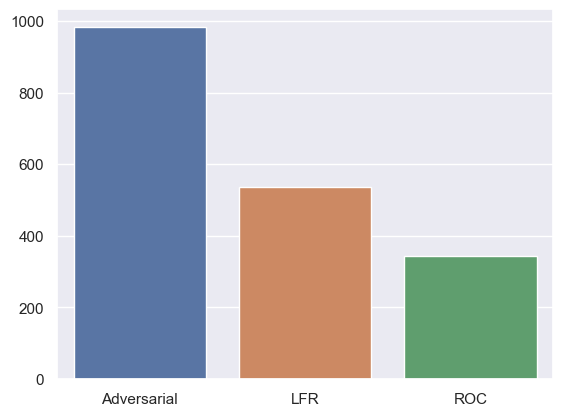

In [48]:
sns.barplot(
    x=['Adversarial', 'LFR', 'ROC'],
    y=[len(t[t.adv_change!=0]), len(t[t.lfr_change!=0]), len(t[t.roc_change!=0])]
           )

<AxesSubplot:>

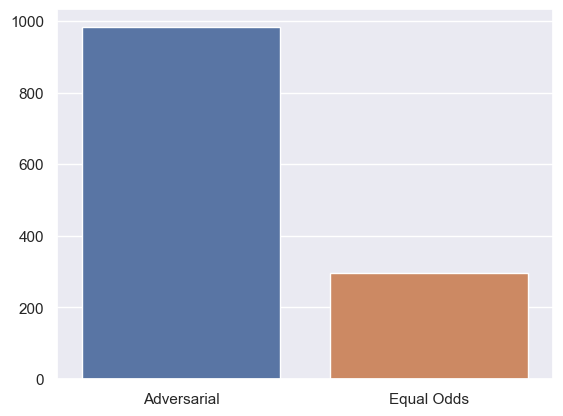

In [49]:
sns.barplot(
    x=['Adversarial', 'Equal Odds'],
    y=[len(t[t.adv_change!=0]), len(t[t.eq_change!=0])]
           )

## IOU + final statte

In [50]:
tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0)]
inters_dp = len(tt[(tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change)])
union_dp = len(tt)
iou_dp = inters_dp/union_dp * 100

print('Demographic parity methods:')
print(f'IOU(changed instances) = {iou_dp:.2f}%')

tt = t[(t.adveq_change!=0) | (t.eq_change!=0)]
inters_eo = len(tt[(tt.adveq_change==tt.eq_change)])
union_eo = len(tt)
iou_eo = inters_eo/union_eo * 100

print('Equalized Odds methods:')
print(f'IOU(changed instances) = {iou_eo:.2f}%')

tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0) | (t.adveq_change!=0) | (t.eq_change!=0)]
inters = len(tt[
    (tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change) &
    (tt.adveq_change==tt.eq_change) &
    (tt.adv_change==tt.adveq_change) & (tt.lfr_change==tt.adveq_change) & (tt.roc_change==tt.adveq_change) &
    (tt.adv_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
])
union = len(tt)
iou = inters/union

print('All methods:')
print(f'IOU(changed instances) = {iou:.2f}%')

Demographic parity methods:
IOU(changed instances) = 7.53%
Equalized Odds methods:
IOU(changed instances) = 19.51%
All methods:
IOU(changed instances) = 0.00%


In [51]:
print('Adversarial:')
print(f'disadv group in positive class: {len(t[(t.race==0) & (t.adv_pred==1)]) / len(t[t.race==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.race==1) & (t.adv_pred==1)]) / len(t[t.race==1]) * 100:.2f}%')
print()

print('ROC:')
print(f'disadv group in positive class: {len(t[(t.race==0) & (t.roc_pred==1)]) / len(t[t.race==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.race==1) & (t.roc_pred==1)]) / len(t[t.race==1]) * 100:.2f}%')
print()

print('LFR:')
print(f'disadv group in positive class: {len(t[(t.race==0) & (t.lfr_pred==1)]) / len(t[t.race==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.race==1) & (t.lfr_pred==1)]) / len(t[t.race==1]) * 100:.2f}%')
print()

print('Biased:')
print(f'disadv group in positive class: {len(t[(t.race==0) & (t.biased_pred==1)]) / len(t[t.race==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.race==1) & (t.biased_pred==1)]) / len(t[t.race==1]) * 100:.2f}%')
print()

Adversarial:
disadv group in positive class: 43.08%
priv group in positive class: 34.85%

ROC:
disadv group in positive class: 39.73%
priv group in positive class: 41.86%

LFR:
disadv group in positive class: 60.33%
priv group in positive class: 54.55%

Biased:
disadv group in positive class: 39.73%
priv group in positive class: 74.34%



In [52]:
test_results.to_csv('../../results/compas/test_results.csv')

# T-sne and PCA

In [53]:
t.head()

race  biased_pred  target  lfr_pred  lfr_change  adv_pred  adv_change  \
6401     0          0.0       0       0.0         0.0       0.0         0.0   
108      1          1.0       1       1.0         0.0       0.0        -1.0   
6770     1          1.0       0       1.0         0.0       0.0        -1.0   
4968     1          1.0       1       1.0         0.0       0.0        -1.0   
890      0          1.0       0       1.0         0.0       1.0         0.0   

      eq_pred  eq_change  adveq_pred  adveq_change  roc_pred  roc_change  
6401        0        0.0           0           0.0       0.0         0.0  
108         1        0.0           1           0.0       1.0         0.0  
6770        1        0.0           1           0.0       0.0        -1.0  
4968        1        0.0           1           0.0       0.0        -1.0  
890         1        0.0           0          -1.0       1.0         0.0

In [54]:
a_df = t[t.adv_change!=0]
l_df = t[t.lfr_change!=0]
r_df = t[t.roc_change!=0]
ae_df = t[t.adveq_change!=0]
e_df = t[t.eq_change!=0]

In [72]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(X_test)


In [86]:
def tsne_plot(tsne_df, methods, colors_map):
    """
    data: tsne axes
    methods: dict {method_name: df_changed_by_method}
    colors_map: dict{method_name: color}
    """
    
    df = X_test.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])
    
    plot_dfs = {}
    for m in methods.keys():
        plot_dfs[m] = df.loc[methods[m].index]
        
    fig, axs = plt.subplots(1, 1, figsize = (10,6))
    
    sns.kdeplot(data=df, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.05, alpha=0.4, legend=True, color='Grey', cut=0.5)
    
    patch_all = mpatches.Patch(
        color='Grey', label='All Instances'
    )
    
    patches=[patch_all]
    
    for m in plot_dfs.keys():
        sns.kdeplot(data=plot_dfs[m], x='c1', y='c2', ax=axs, label='ROC', fill=False, thresh=0.4, color=colors_map[m])
        patch = mpatches.Patch(color=colors_map[m], label=m)
        patches.append(patch)
        
    axs.legend(handles=patches)
    axs.set_title('T-SNE projection of Datapoints')
    plt.tight_layout()
    
    return tsne_df

In [74]:
pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2'])

c1         c2
6401 -10.369078   7.210668
108   17.165823  15.567580
6770 -29.404694 -33.759136
4968  24.408791  50.174438
890   35.191483 -35.380775
...         ...        ...
1929 -39.034672 -19.042910
3076 -40.828190  -9.236589
1483 -27.109642 -16.223955
1422 -33.290131  -5.460342
2576 -33.734188  -9.285755

[2639 rows x 2 columns]

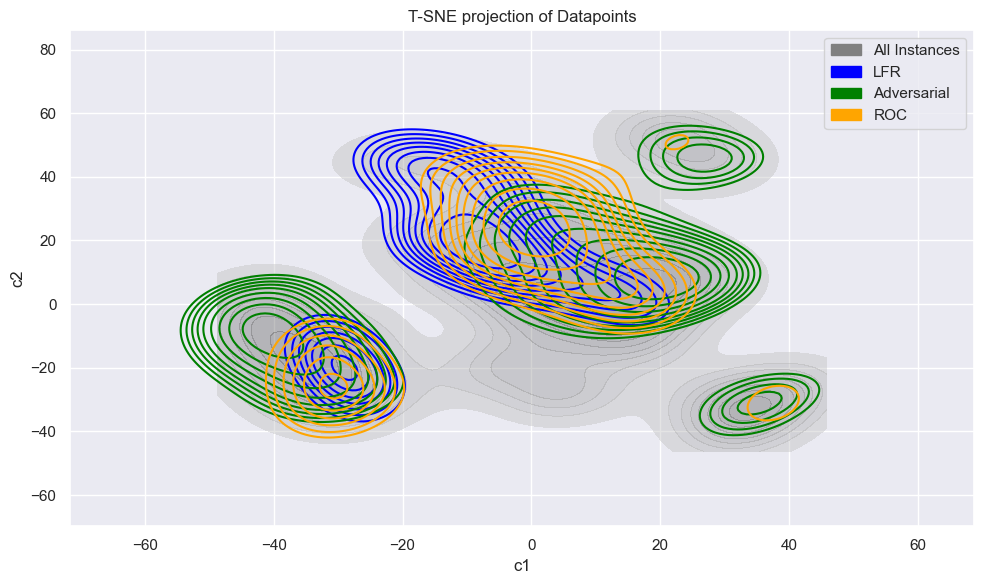

In [77]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'LFR': l_df, 'Adversarial':a_df, 'ROC':r_df},
    {'LFR': 'Blue', 'Adversarial':'Green', 'ROC':'Orange'}
)

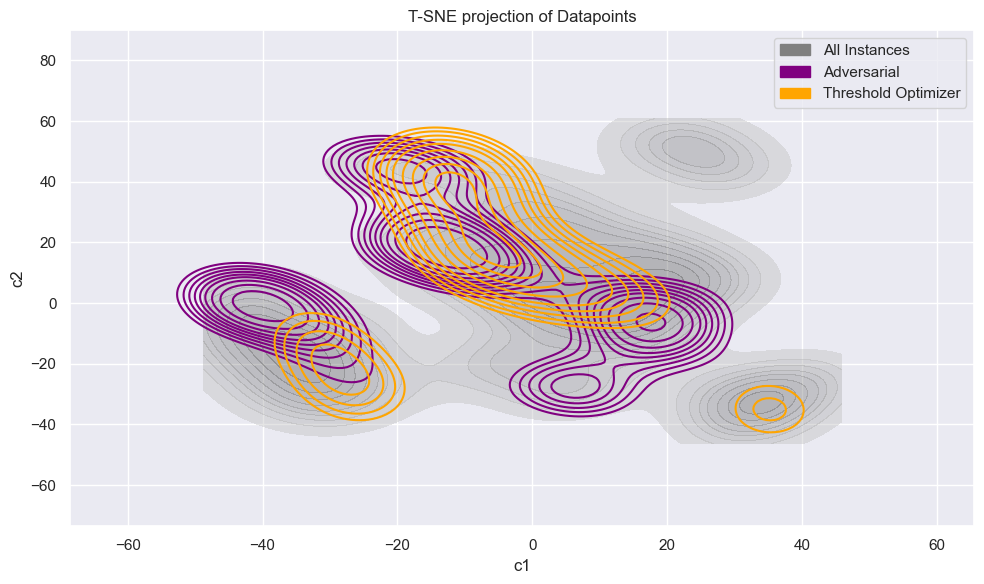

In [79]:
tsne_df = tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'Adversarial': ae_df, 'Threshold Optimizer':e_df},
    {'Adversarial':'Purple', 'Threshold Optimizer':'Orange'}
)

In [168]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        return self.model.predict(self.lfr.transform(bld)).labels
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        X = XZ.drop(columns = ['race'])
        y = pd.Series(np.zeros(len(X)), name='score_factor')
        Z = XZ['race']
        
        return self.model.predict(
            X=X, y=y, Z=Z, sensitive_features=Z,
            bld=bld
        )
    
class Adversarial_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        return self.model.predict(bld).labels

In [169]:
lfr_wrap = LFR_model(lfr, model)
eq_wrap = EQ_model(m)
adv_wrap = Adversarial_model(debiased_model)
biased_wrap = Adversarial_model(biased_model)

#fpool = pool.FairnessPool([lfr_wrap, eq_wrap, adv_wrap, biased_wrap], 
#                          ['LFR', 'Equal Odds', 'Adversarial', 'Biased'],
#                         'race')

eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'race')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'race')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'race')

In [170]:
adv_pool.predict(XZ=X_test.join(y_test).join(Z_test))

Adversarial  Biased
6401          1.0     0.0
108           1.0     1.0
6770          1.0     1.0
4968          1.0     1.0
890           1.0     1.0
...           ...     ...
1929          1.0     1.0
3076          1.0     1.0
1483          0.0     0.0
1422          1.0     0.0
2576          1.0     0.0

[2639 rows x 2 columns]

In [88]:
sample = X_test.join(Z_test).join(y_test).sample(100).assign(score_factor=0)
bld_sample = BinaryLabelDataset(
    df=sample,
    label_names=['score_factor'],
    protected_attribute_names=['race']
)

In [89]:
sample.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  \
7083  0.501302 -1.054651      0.981127      -0.147441        1.740255   
1568  0.501302  0.992841      2.471494      -0.147441       -0.195889   
1501  0.501302 -0.628090      0.129488      -0.147441       -0.195889   
6440  0.501302  1.590025      3.536042      -0.147441       -0.195889   
3153  0.501302  2.357835      2.045675      -0.147441       -0.195889   

        felony  race  score_factor  
7083  0.744434     0             0  
1568  0.744434     0             0  
1501  0.744434     1             0  
6440  0.744434     0             0  
3153  0.744434     0             0

In [90]:
adv_pool.predict_discrepancies(sample)

Adversarial  Biased  discrepancies
7083          0.0     0.0              0
1568          1.0     0.0              1
1501          0.0     0.0              0
6440          0.0     0.0              0
3153          1.0     0.0              1
...           ...     ...            ...
6274          1.0     0.0              1
6205          1.0     1.0              0
6959          1.0     1.0              0
113           1.0     1.0              0
1978          0.0     0.0              0

[100 rows x 3 columns]

In [100]:
eq_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    eq_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


epoch 1
(165, 7)
epoch 2
(564, 7)


INFO:root:### EPOCH #3


epoch 3
(1115, 7)


INFO:root:### EPOCH #4


epoch 4
(1885, 7)


INFO:root:### EPOCH #5


epoch 5
(3279, 7)


INFO:root:### EPOCH #6


epoch 6
(5949, 7)


INFO:root:### EPOCH #7


epoch 7
(11164, 7)


In [101]:
adv_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    adv_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2


epoch 1
(170, 7)
epoch 2
(546, 7)


INFO:root:### EPOCH #3


epoch 3
(928, 7)


INFO:root:### EPOCH #4


epoch 4
(1398, 7)


INFO:root:### EPOCH #5


epoch 5
(2308, 7)


INFO:root:### EPOCH #6


epoch 6
(4123, 7)


INFO:root:### EPOCH #7


epoch 7
(7731, 7)


In [103]:
nodes = pd.concat([adv_digger.get_nodes_attributes(adv_digger.get_nodes())[0],
           adv_digger.get_nodes_attributes(adv_digger.get_nodes())[1]],
         axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))

nodes.head()#[nodes.isna().any(axis=1)]

sex       age  priors_count  juv_fel_count  juv_misd_count  \
7083  0.501302 -1.054651      0.981127      -0.147441        1.740255   
1568  0.501302  0.992841      2.471494      -0.147441       -0.195889   
1501  0.501302 -0.628090      0.129488      -0.147441       -0.195889   
6440  0.501302  1.590025      3.536042      -0.147441       -0.195889   
3153  0.501302  2.357835      2.045675      -0.147441       -0.195889   

        felony  race  Adversarial  Biased  discrepancy  
7083  0.744434   0.0          0.0     0.0            0  
1568  0.744434   0.0          1.0     0.0            1  
1501  0.744434   1.0          0.0     0.0            0  
6440  0.744434   0.0          0.0     0.0            0  
3153  0.744434   0.0          1.0     0.0            1

In [104]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[X_test.columns]), columns=X_test.columns,
            index=nodes.index)
nodes_unscaled.head()

sex   age  priors_count  juv_fel_count  juv_misd_count  felony
7083  1.0  22.0           8.0            0.0             1.0     1.0
1568  1.0  46.0          15.0            0.0             0.0     1.0
1501  1.0  27.0           4.0            0.0             0.0     1.0
6440  1.0  53.0          20.0            0.0             0.0     1.0
3153  1.0  62.0          13.0            0.0             0.0     1.0

In [105]:
dff = pd.concat([
    nodes_unscaled,
    nodes[['race', 'Adversarial', 'Biased']]
], axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))\
  .drop(columns=['Adversarial', 'Biased'])\
  .assign(race = lambda x: (x.race>0.5).astype(int))
dff.head()

sex   age  priors_count  juv_fel_count  juv_misd_count  felony  race  \
7083  1.0  22.0           8.0            0.0             1.0     1.0     0   
1568  1.0  46.0          15.0            0.0             0.0     1.0     0   
1501  1.0  27.0           4.0            0.0             0.0     1.0     1   
6440  1.0  53.0          20.0            0.0             0.0     1.0     0   
3153  1.0  62.0          13.0            0.0             0.0     1.0     0   

      discrepancy  
7083            0  
1568            1  
1501            0  
6440            0  
3153            1

In [106]:
testx.describe()

sex          age  priors_count  juv_fel_count  juv_misd_count  \
count  2639.000000  2639.000000   2639.000000    2639.000000      2639.00000   
mean      0.810155    34.536567      3.531262       0.063282         0.09587   
std       0.392252    11.742922      5.047732       0.416869         0.51760   
min       0.000000    18.000000      0.000000       0.000000         0.00000   
25%       1.000000    25.000000      0.000000       0.000000         0.00000   
50%       1.000000    31.000000      2.000000       0.000000         0.00000   
75%       1.000000    42.000000      5.000000       0.000000         0.00000   
max       1.000000    79.000000     38.000000       8.000000        12.00000   

            felony  
count  2639.000000  
mean      0.660099  
std       0.473765  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000

In [370]:
dff.describe()

sex          age  priors_count  juv_fel_count  juv_misd_count  \
count  6936.000000  6936.000000   6936.000000    6936.000000     6936.000000   
mean      0.859141    34.198822      4.258077       0.030209        0.065037   
std       0.347901     8.946265      3.062195       0.133355        0.305021   
min       0.000000    20.000000      0.000000       0.000000        0.000000   
25%       1.000000    27.125000      1.875000       0.000000        0.000000   
50%       1.000000    32.500000      4.000000       0.000000        0.000000   
75%       1.000000    40.000000      6.250000       0.000000        0.000000   
max       1.000000    77.000000     23.000000       3.000000        8.000000   

            felony         race  discrepancy  
count  6936.000000  6936.000000  6936.000000  
mean      0.640138     0.201845     0.594435  
std       0.479994     0.401406     0.491036  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       1.000000     0.000000     1.000000  
75%       1.000000     0.000000     1.000000  
max       1.000000     1.000000     1.000000

In [371]:
sc_dfff = nodes.assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int)).drop(columns=['Adversarial', 'Biased', 'race'])

In [430]:
#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['discrepancy']),
#                                                                       dff[['discrepancy']],
#                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)

#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(sc_dfff.drop(columns=['discrepancy']),
#                                                                       sc_dfff[['discrepancy']],
#                                                                       test_size=0.5, stratify=sc_dfff[['discrepancy']], random_state=11)

ValueError: not enough values to unpack (expected 4, got 2)

In [373]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(x_tree_train.to_numpy(), y_tree_train)

In [374]:
preds = clf.predict(x_tree_test)

metrics.balanced_accuracy_score(y_tree_test, preds)

0.7865128388381235

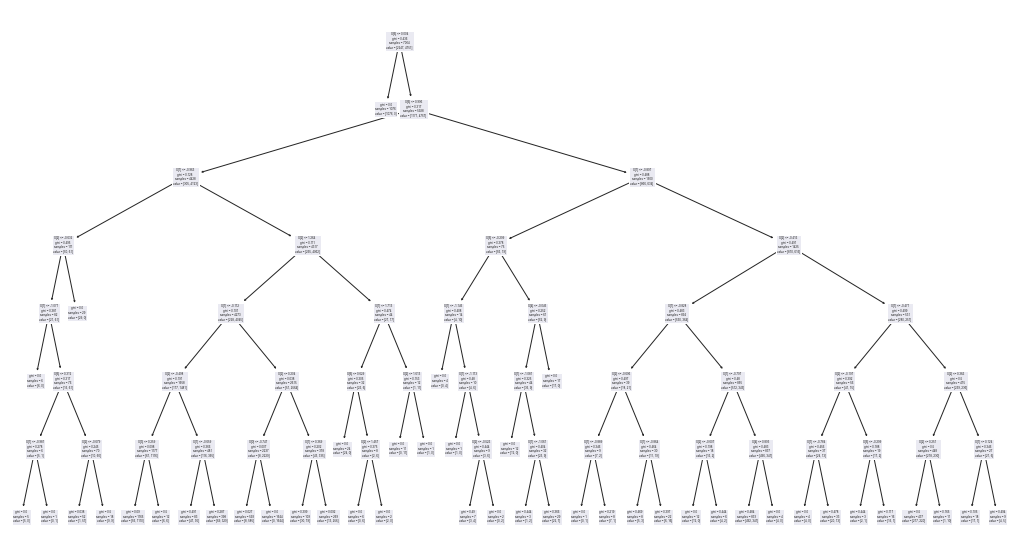

In [436]:
from sklearn import tree

fig, axs = plt.subplots(1,1,figsize=(18,10))

tree.plot_tree(clf)

plt.show()

In [375]:
list(X_test.columns)+['race']

['sex',
 'age',
 'priors_count',
 'juv_fel_count',
 'juv_misd_count',
 'felony',
 'race']

In [376]:
dff.race.unique()

array([0, 1])

In [495]:
import graphviz

In [377]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)
#graph.render('adult'),

In [378]:
graph.render('compas_adv')

'compas_adv.pdf'

In [379]:
leaves = clf.apply(x_tree_test)

In [380]:
tree_df = pd.DataFrame(scaler.inverse_transform(x_tree_test), columns=x_tree_test.columns, index=x_tree_test.index)\
            .assign(leaf=leaves).assign(discrepancy=y_tree_test)
tree_df.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  felony  \
-4410  1.0  25.00000       0.75000        0.00000             0.0     1.0   
-2232  1.0  33.71875       1.46875        0.28125             0.0     1.0   
-5394  1.0  24.68750       1.00000        0.21875             0.0     1.0   
-5236  0.0  25.62500       1.12500        0.00000             0.0     0.0   
-69    1.0  55.50000       3.00000        0.00000             0.0     0.0   

       leaf  discrepancy  
-4410    96            1  
-2232   228            0  
-5394    96            1  
-5236    44            0  
-69     238            0

In [381]:
tree_df.groupby(['leaf', 'discrepancy']).count().reset_index().sort_values(['discrepancy', 'sex'], ascending=False)[0:10] #.sort_values('sex')

leaf  discrepancy  sex  age  priors_count  juv_fel_count  juv_misd_count  \
221   315            1  528  528           528            528             528   
181   263            1  277  277           277            277             277   
69     96            1  173  173           173            173             173   
91    115            1  138  138           138            138             138   
81    107            1   67   67            67             67              67   
85    111            1   65   65            65             65              65   
223   316            1   62   62            62             62              62   
197   281            1   43   43            43             43              43   
16     24            1   38   38            38             38              38   
89    114            1   33   33            33             33              33   

     felony  
221     528  
181     277  
69      173  
91      138  
81       67  
85       65  
223      62  
197      43  
16       38  
89       33

In [382]:
x_tree_test.shape

(3468, 6)

In [384]:
tree_df[tree_df.leaf==315].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

Gender        Age   Priors  Juvenial Felonies  Juvenial Misdemeanors  \
min     0.0  32.039062   6.0625             0.0000                  0.000   
max     1.0  51.312500  11.0625             0.3125                  0.875   

     Felony  
min     0.0  
max     1.0

In [385]:
tree_df[tree_df.leaf==263].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

Gender      Age   Priors  Juvenial Felonies  Juvenial Misdemeanors  \
min     0.0  30.1250  4.06250              0.000                0.00000   
max     1.0  35.0625  6.03125              0.375                0.96875   

     Felony  
min     0.0  
max     1.0

In [349]:
tree_df.head()

sex      age  priors_count  juv_fel_count  juv_misd_count  felony  \
-2229  1.0  44.1250        0.5000            0.0             0.0     1.0   
-5351  0.0  33.6875        1.5625            0.0             0.0     1.0   
-5133  1.0  35.0625        3.3125            0.0             0.0     1.0   
-5673  0.0  25.5625        0.1250            0.0             0.0     1.0   
-1212  0.0  28.7500        0.5000            0.0             0.0     0.0   

       leaf  discrepancy  
-2229   371            1  
-5351   345            1  
-5133   357            1  
-5673    37            0  
-1212   141            1

In [509]:
t.groupby(['race', 'eq_change']).count()

biased_pred  lfr_pred  adv_pred  eq_label  adv_change  \
race eq_change                                                          
0     0.0              1582      1582      1582      1582        1582   
      1.0                 1         1         1         1           1   
1    -1.0               351       351       351       351         351   
      0.0               705       705       705       705         705   

                lfr_change  eq_pred  target  
race eq_change                               
0     0.0             1582     1582    1582  
      1.0                1        1       1  
1    -1.0              351      351     351  
      0.0              705      705     705

In [442]:
x_tree_train.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  \
-8068  -1.994805  0.163713     -0.356212      -0.147441       -0.195889   
-11446  0.501302 -0.921350     -0.675576      -0.147441       -0.195889   
-12845  0.501302  1.709996     -0.722150      -0.147441       -0.195889   
-4267   0.501302 -0.660082     -0.482627      -0.147441       -0.195889   
-86     0.501302 -0.180201      0.821445       1.091719       -0.195889   

          felony     race  
-8068   0.744434  0.65625  
-11446  0.744434  0.78125  
-12845  0.744434  1.00000  
-4267   0.744434  0.81250  
-86    -1.343303  0.00000

In [446]:
nodes.assign()

array([0.       , 1.       , 0.5      , 0.75     , 0.25     , 0.875    ,
       0.625    , 0.375    , 0.125    , 0.8125   , 0.9375   , 0.6875   ,
       0.5625   , 0.4375   , 0.1875   , 0.0625   , 0.84375  , 0.96875  ,
       0.90625  , 0.78125  , 0.3125   , 0.71875  , 0.65625  , 0.53125  ,
       0.59375  , 0.46875  , 0.09375  , 0.15625  , 0.21875  , 0.03125  ,
       0.828125 , 0.921875 , 0.984375 , 0.953125 , 0.796875 , 0.890625 ,
       0.859375 , 0.34375  , 0.40625  , 0.28125  , 0.765625 , 0.734375 ,
       0.640625 , 0.671875 , 0.703125 , 0.609375 , 0.546875 , 0.578125 ,
       0.515625 , 0.484375 , 0.140625 , 0.046875 , 0.078125 , 0.203125 ,
       0.171875 , 0.109375 , 0.015625 , 0.8515625, 0.8046875, 0.8203125,
       0.9609375, 0.9765625, 0.8359375, 0.9296875, 0.8984375, 0.9140625,
       0.8828125, 0.9453125, 0.9921875, 0.8671875, 0.390625 , 0.359375 ,
       0.328125 , 0.453125 , 0.421875 , 0.234375 , 0.265625 , 0.296875 ,
       0.7890625, 0.7734375, 0.7421875, 0.6796875, 

In [577]:
t.head()

race  biased_pred  lfr_pred  adv_pred  eq_label  eq_change  adv_change  \
6401     0          0.0       0.0       1.0         0        0.0         1.0   
108      1          1.0       1.0       1.0         1        0.0         0.0   
6770     1          1.0       1.0       1.0         1        0.0         0.0   
4968     1          1.0       1.0       1.0         1        0.0         0.0   
890      0          1.0       1.0       1.0         1        0.0         0.0   

      lfr_change  eq_pred  target  
6401         0.0        0       0  
108          0.0        1       1  
6770         0.0        1       0  
4968         0.0        1       1  
890          0.0        1       0

In [317]:
t.head()

race  biased_pred  lfr_pred  adv_pred  eq_label  eq_change  adv_change  \
6401     0          0.0       0.0       0.0         0        0.0         0.0   
108      1          1.0       1.0       1.0         0       -1.0         0.0   
6770     1          1.0       1.0       1.0         1        0.0         0.0   
4968     1          1.0       1.0       1.0         0       -1.0         0.0   
890      0          1.0       1.0       1.0         1        0.0         0.0   

      lfr_change  eq_pred  target  
6401         0.0        0       0  
108          0.0        0       1  
6770         0.0        1       0  
4968         0.0        0       1  
890          0.0        1       0

In [324]:
plot_df = dd.loc[t.index].assign(
    eq_change = t.eq_change,
    adv_change = t.adv_change,
    lfr_change = t.lfr_change
)

In [330]:
plot_df[plot_df.eq_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

age  priors_count  juv_fel_count  juv_misd_count
count  326.000000    326.000000          326.0           326.0
mean    40.972393      1.509202            0.0             0.0
std     12.554956      2.574115            0.0             0.0
min     20.000000      0.000000            0.0             0.0
25%     30.000000      0.000000            0.0             0.0
50%     41.000000      1.000000            0.0             0.0
75%     51.000000      2.000000            0.0             0.0
max     79.000000     23.000000            0.0             0.0

In [336]:
plot_df[plot_df.eq_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'}).assign(method='Equal Odds').reset_index()

race  sex      method
0     0    1  Equal Odds
1     1  325  Equal Odds

In [333]:
plot_df[plot_df.lfr_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

sex
race     
0     326
1     209

In [334]:
plot_df[plot_df.adv_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

sex
race     
0     494
1     117

In [329]:
plot_df[plot_df.lfr_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

age  priors_count  juv_fel_count  juv_misd_count
count  535.000000    535.000000          535.0      535.000000
mean    28.742056      2.312150            0.0        0.005607
std      9.021448      2.657359            0.0        0.074743
min     19.000000      0.000000            0.0        0.000000
25%     22.000000      0.000000            0.0        0.000000
50%     26.000000      1.000000            0.0        0.000000
75%     32.000000      4.000000            0.0        0.000000
max     71.000000     14.000000            0.0        1.000000

In [388]:
testx.head()

sex  age  priors_count  juv_fel_count  juv_misd_count  felony
6401    1   22             3              0               0       1
108     1   43             1              0               0       1
6770    1   23             0              0               0       0
4968    0   33             1              0               0       0
890     0   29             1              0               0       1

In [389]:
from sklearn.cluster import AgglomerativeClustering

In [409]:
clusters = AgglomerativeClustering(n_clusters=10).fit_predict(nodes[nodes.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [411]:
agl_clusters = nodes[nodes.discrepancy==1].assign(cluster=clusters)
agl_clusters.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  \
782   0.501302 -1.054651     -0.722150      -0.147441       -0.195889   
5665  0.501302 -0.372154      0.555308      -0.147441       -0.195889   
5310  0.501302 -0.030905      0.342398      -0.147441       -0.195889   
6846  0.501302  0.907528      0.555308      -0.147441       -0.195889   
4592  0.501302 -0.542778     -0.296331      -0.147441       -0.195889   

        felony  race  Adversarial  Biased  discrepancy  cluster  
782   0.744434   1.0          0.0     1.0            1        3  
5665  0.744434   0.0          1.0     0.0            1        1  
5310 -1.343303   0.0          1.0     0.0            1        4  
6846  0.744434   0.0          1.0     0.0            1        0  
4592  0.744434   1.0          0.0     1.0            1        3

In [428]:
from sklearn.cluster import AffinityPropagation

AffinityPropagation().fit_predict(trainx[trainx.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

AttributeError: 'DataFrame' object has no attribute 'discrepancy'

In [424]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(agl_clusters.drop(columns=['discrepancy', 'Adversarial', 'Biased', 'cluster']))


In [425]:
all_df = agl_clusters.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

all_df.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  \
782   0.501302 -1.054651     -0.722150      -0.147441       -0.195889   
5665  0.501302 -0.372154      0.555308      -0.147441       -0.195889   
5310  0.501302 -0.030905      0.342398      -0.147441       -0.195889   
6846  0.501302  0.907528      0.555308      -0.147441       -0.195889   
4592  0.501302 -0.542778     -0.296331      -0.147441       -0.195889   

        felony  race  Adversarial  Biased  discrepancy  cluster         c1  \
782   0.744434   1.0          0.0     1.0            1        3 -18.370071   
5665  0.744434   0.0          1.0     0.0            1        1   0.149525   
5310 -1.343303   0.0          1.0     0.0            1        4 -34.406033   
6846  0.744434   0.0          1.0     0.0            1        0  39.072807   
4592  0.744434   1.0          0.0     1.0            1        3   1.002677   

             c2  
782  -48.270870  
5665  21.521152  
5310  15.109587  
6846  14.790672  
4592 -40.298885

<AxesSubplot: xlabel='c1', ylabel='c2'>

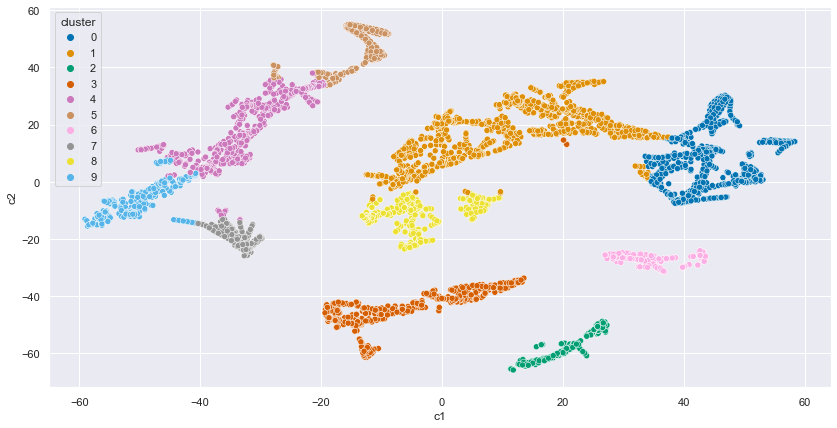

In [426]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', hue='cluster', palette='colorblind')

<AxesSubplot: xlabel='c1', ylabel='c2'>

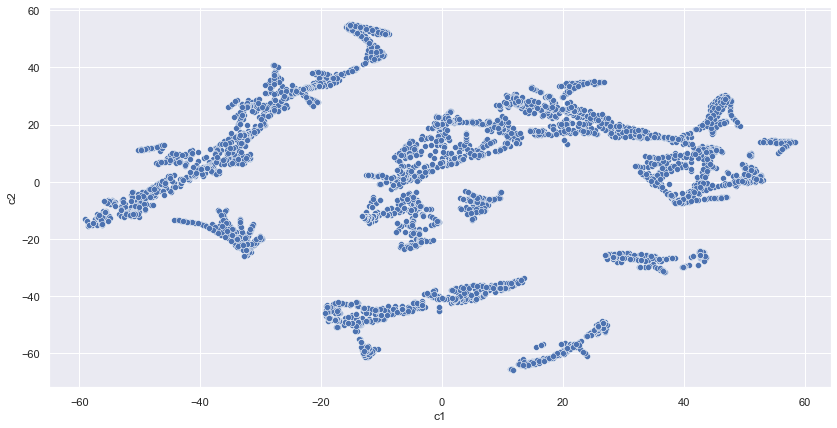

In [427]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', palette='colorblind')

In [423]:
all_df[all_df.cluster==1].describe()[['age', '']]

sex         age  priors_count  juv_fel_count  juv_misd_count  \
count  9.640000e+02  964.000000    964.000000     964.000000      964.000000   
mean   5.013022e-01   -0.083837      0.415075      -0.096184       -0.173545   
std    4.776437e-15    0.336965      0.313801       0.184716        0.108224   
min    5.013022e-01   -0.900022     -0.296331      -0.147441       -0.195889   
25%    5.013022e-01   -0.318833      0.169409      -0.147441       -0.195889   
50%    5.013022e-01   -0.108219      0.472140      -0.147441       -0.195889   
75%    5.013022e-01    0.139719      0.661762      -0.147441       -0.195889   
max    5.013022e-01    0.827548      1.406946       1.324062        0.832688   

             felony        race  Adversarial  Biased  discrepancy  cluster  \
count  9.640000e+02  964.000000        964.0   964.0        964.0    964.0   
mean   7.444336e-01    0.034589          1.0     0.0          1.0      1.0   
std    6.775876e-15    0.083794          0.0     0.0          0.0      0.0   
min    7.444336e-01    0.000000          1.0     0.0          1.0      1.0   
25%    7.444336e-01    0.000000          1.0     0.0          1.0      1.0   
50%    7.444336e-01    0.000000          1.0     0.0          1.0      1.0   
75%    7.444336e-01    0.000000          1.0     0.0          1.0      1.0   
max    7.444336e-01    0.500000          1.0     0.0          1.0      1.0   

               c1          c2  
count  964.000000  964.000000  
mean    -7.245269  -21.774036  
std     13.220804    5.638899  
min    -33.608570  -30.931047  
25%    -17.542603  -26.579922  
50%     -6.450139  -21.775984  
75%      3.854169  -17.945270  
max     16.774687   -6.585335

In [422]:
len(all_df)

4123

<AxesSubplot: xlabel='c1', ylabel='c2'>

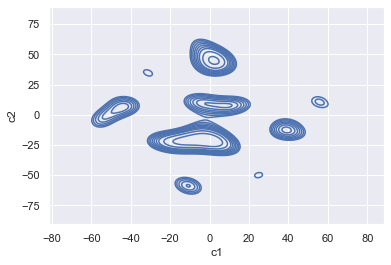

In [418]:
sns.kdeplot(data=all_df, x='c1', y='c2', thresh = 0.6)

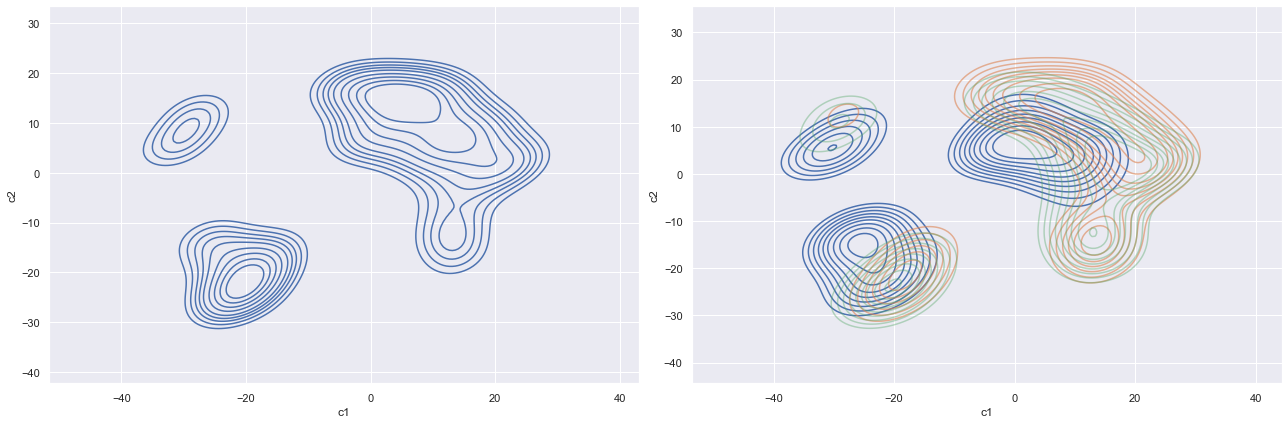

In [111]:
all_df = changed.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

fig, axs = plt.subplots(1,1, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=all_df, x='c1', y='c2', ax=axs, label='All Instances', fill=False, thresh=0.3)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

In [200]:
t.head()

race  biased_pred  lfr_pred  adv_pred  eq_label  eq_change  adv_change  \
6401     0          0.0       0.0       1.0         0        0.0         1.0   
108      1          1.0       1.0       1.0         1        0.0         0.0   
6770     1          1.0       1.0       1.0         0       -1.0         0.0   
4968     1          1.0       1.0       1.0         1        0.0         0.0   
890      0          1.0       1.0       1.0         1        0.0         0.0   

      lfr_change  eq_pred  target  
6401         0.0        0       0  
108          0.0        1       1  
6770         0.0        0       0  
4968         0.0        1       1  
890          0.0        1       0

In [202]:
y_tree = (t.biased_pred!=t.adv_pred).astype(int)

In [227]:
(X_train_og, X_test_og, _, _,
     _, _) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

og_scaler = StandardScaler().fit(X_train_og)

In [188]:
check = pd.concat([pd.DataFrame(og_scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns), 
           X_test_og], axis=1)
check[check.sex!=check.sex_og]

Empty DataFrame
Columns: [sex, age, priors_count, juv_fel_count, juv_misd_count, felony, sex_og, age_og, priors_count_og, juv_fel_count_og, juv_misd_count_og, felony_og]
Index: []

In [228]:
X_test_og.columns = X_test_og.columns.map(lambda x: x+'_og')

In [196]:
tree_data = X_test.assign(race=Z_test)

scaler = StandardScaler().fit(tree_data)

scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
tree_data = tree_data.pipe(scale_df, scaler)

In [197]:
tree_data.head()

sex       age  priors_count  juv_fel_count  juv_misd_count  \
6401  0.484078 -1.067787     -0.105268      -0.151831       -0.185255   
108   0.484078  0.720863     -0.501560      -0.151831       -0.185255   
6770  0.484078 -0.982613     -0.699707      -0.151831       -0.185255   
4968 -2.065784 -0.130875     -0.501560      -0.151831       -0.185255   
890  -2.065784 -0.471571     -0.501560      -0.151831       -0.185255   

        felony      race  
6401  0.717583 -0.816754  
108   0.717583  1.224358  
6770 -1.393567  1.224358  
4968 -1.393567  1.224358  
890   0.717583 -0.816754

In [299]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=6)
clf = clf.fit(tree_data.to_numpy(), y_tree)

In [300]:
preds = clf.predict(tree_data)

metrics.balanced_accuracy_score(y_tree, preds)

0.8628560284229181

In [301]:
clusters = clf.apply(tree_data)

In [302]:
cc = pd.DataFrame(og_scaler.inverse_transform(pd.DataFrame(scaler.inverse_transform(tree_data), 
                                         index=tree_data.index,
                                         columns=tree_data.columns).drop(columns=['race'])),
            index=tree_data.index,
            columns=X_test.columns)
cc = cc.assign(
    priors_count = round(cc.priors_count),
    juv_fel_count = round(cc.juv_fel_count)
)

In [303]:
cc = cc.assign(segment=clusters, y=y_tree)
cc.head()

sex   age  priors_count  juv_fel_count  juv_misd_count  felony  segment  \
6401  1.0  22.0           3.0            0.0             0.0     1.0       26   
108   1.0  43.0           1.0            0.0             0.0     1.0       93   
6770  1.0  23.0           0.0            0.0             0.0     0.0       61   
4968  0.0  33.0           1.0            0.0             0.0     0.0       80   
890   0.0  29.0           1.0            0.0             0.0     1.0       39   

      y  
6401  1  
108   0  
6770  0  
4968  0  
890   0

In [304]:
cc.groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

age
segment     
93       494
51       364
39       286
54       176
22       155

In [309]:
cc[cc.y==1].groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

age
segment     
51       214
22       146
55        46
70        22
52        21

In [312]:
cc[cc.segment==51].describe()

sex         age  priors_count  juv_fel_count  juv_misd_count  \
count  364.0  364.000000    364.000000     364.000000      364.000000   
mean     1.0   30.131868      4.489011       0.101648        0.112637   
std      0.0    4.613930      1.954691       0.484580        0.458714   
min      1.0   24.000000      2.000000       0.000000        0.000000   
25%      1.0   26.000000      3.000000       0.000000        0.000000   
50%      1.0   29.000000      4.000000       0.000000        0.000000   
75%      1.0   33.000000      6.000000       0.000000        0.000000   
max      1.0   41.000000      8.000000       6.000000        5.000000   

           felony  segment           y  
count  364.000000    364.0  364.000000  
mean     0.708791     51.0    0.587912  
std      0.454945      0.0    0.492888  
min      0.000000     51.0    0.000000  
25%      0.000000     51.0    0.000000  
50%      1.000000     51.0    1.000000  
75%      1.000000     51.0    1.000000  
max      1.000000     51.0    1.000000

In [313]:
cc[cc.segment==22].describe()

sex         age  priors_count  juv_fel_count  juv_misd_count  felony  \
count  155.0  155.000000    155.000000          155.0      155.000000   155.0   
mean     1.0   21.490323      0.677419            0.0        0.077419     1.0   
std      0.0    1.021634      0.746729            0.0        0.268122     0.0   
min      1.0   19.000000      0.000000            0.0        0.000000     1.0   
25%      1.0   21.000000      0.000000            0.0        0.000000     1.0   
50%      1.0   21.000000      1.000000            0.0        0.000000     1.0   
75%      1.0   22.000000      1.000000            0.0        0.000000     1.0   
max      1.0   23.000000      2.000000            0.0        1.000000     1.0   

       segment           y  
count    155.0  155.000000  
mean      22.0    0.941935  
std        0.0    0.234623  
min       22.0    0.000000  
25%       22.0    1.000000  
50%       22.0    1.000000  
75%       22.0    1.000000  
max       22.0    1.000000

In [16]:
df = pd.read_csv('../../results/compas/test_results.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
                [['race', 'biased_pred', 'lfr_pred', 'adv_pred', 'eq_pred', 'target']]
df.head()

race  biased_pred  lfr_pred  adv_pred  eq_pred  target
index                                                        
6401      0          0.0       0.0       1.0        0       0
108       1          1.0       1.0       1.0        1       1
6770      1          1.0       1.0       1.0        0       0
4968      1          1.0       1.0       1.0        1       1
890       0          1.0       1.0       1.0        1       0

In [32]:
comp = dd.loc[df.index].assign(
    biased_pred=df.biased_pred,
    adv_pred = df.adv_pred,
    lfr_pred = df.lfr_pred
)
comp.head()

sex  age  race  decile_score  priors_count  juv_fel_count  \
index                                                              
6401     1   22     0             6             3              0   
108      1   43     1             1             1              0   
6770     1   23     1             5             0              0   
4968     0   33     1             3             1              0   
890      0   29     0             5             1              0   

       juv_misd_count  score_factor  felony  biased_pred  adv_pred  lfr_pred  
index                                                                         
6401                0             0       1          0.0       1.0       0.0  
108                 0             1       1          1.0       1.0       1.0  
6770                0             0       0          1.0       1.0       1.0  
4968                0             1       0          1.0       1.0       1.0  
890                 0             0       1          1.0       1.0       1.0

In [33]:
data = comp[comp.biased_pred != comp.adv_pred]
data_lfr = comp[comp.biased_pred != comp.lfr_pred]

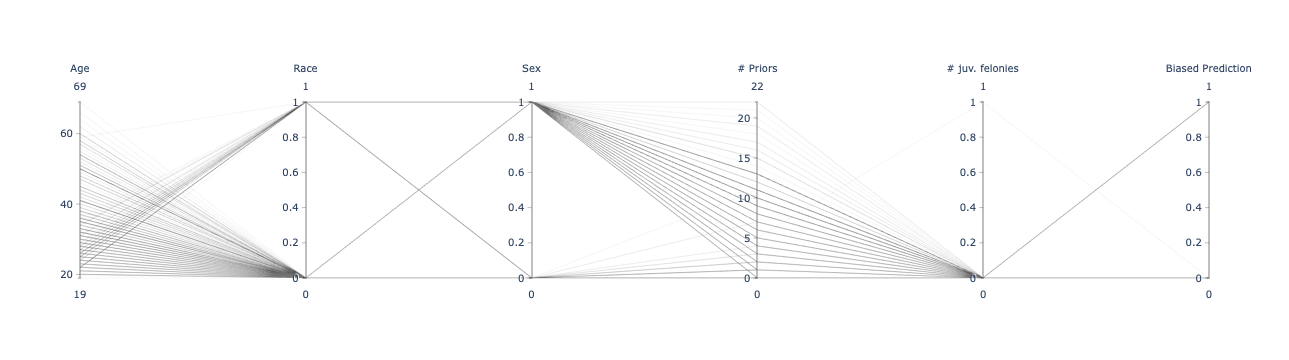

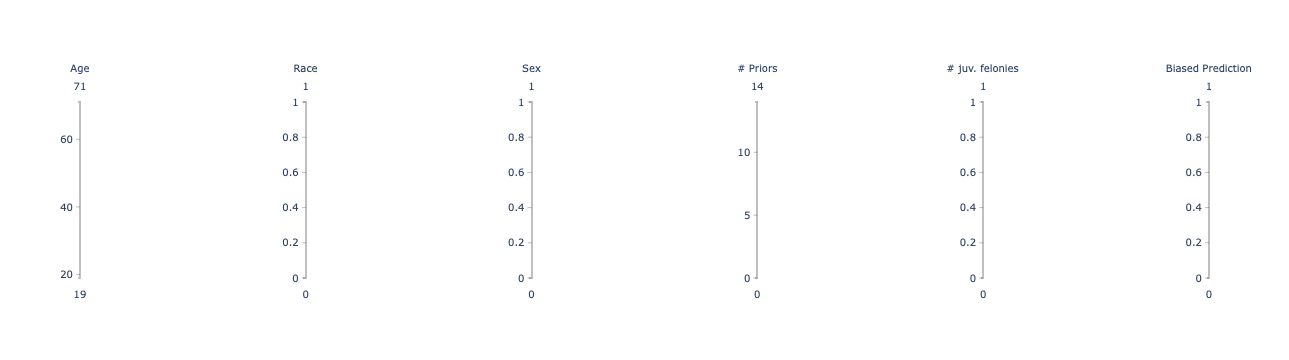

In [39]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data.age.min(), data.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data.priors_count.min(), data.priors_count.max() ],
                 label = '# Priors', values = data.priors_count),
            
            dict(range = [data.juv_fel_count.min(), data.juv_fel_count.max()],
                 label='# juv. felonies', values = data.juv_fel_count
            ),
            dict(range = [data.biased_pred.min(), data.biased_pred.max()],
                 label='Biased Prediction', values = data.biased_pred
            )
        ])
    )
)
fig.show()

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [0, 1],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [40]:
data_lfr.juv_fel_count.max()

0

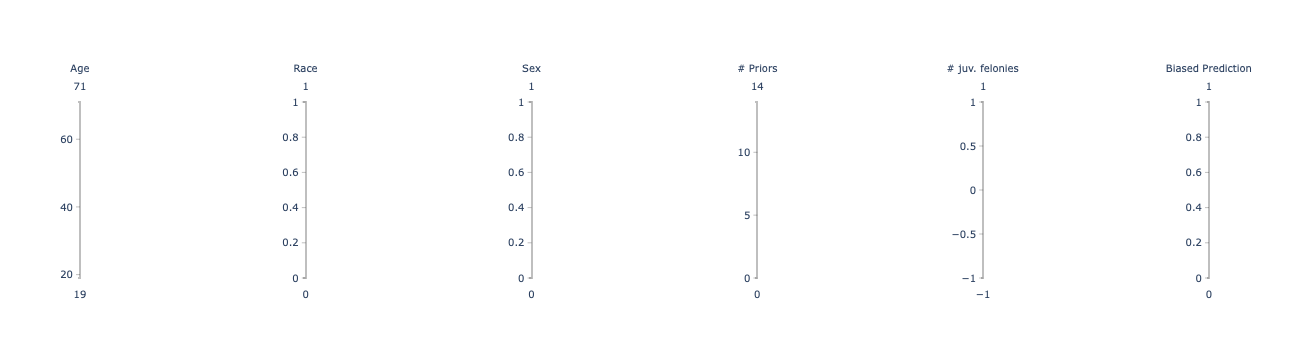

In [34]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [data_lfr.juv_fel_count.min(), data_lfr.juv_fel_count.max()],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [26]:
data.shape

(570, 11)

In [29]:
data[data.sex==0]

sex  age  race  decile_score  priors_count  juv_fel_count  \
index                                                              
3191     0   32     0             2             3              0   
1137     0   24     0             7             0              0   
7184     0   36     1             6             4              0   
3469     0   25     1             4             0              0   
1689     0   28     0             5             2              0   
4810     0   29     1             6             0              0   
5279     0   31     1             2             1              0   
4518     0   23     0             7             0              0   
7017     0   28     0             2             1              0   
4953     0   66     0             8            11              0   
7183     0   24     0             6             0              0   
5245     0   26     0             3             1              0   
5523     0   24     0             3             0              0   
1110     0   32     1             2             1              0   
3560     0   36     0             6             3              0   
3447     0   28     1             4             0              0   
6198     0   24     0             7             0              0   
5072     0   23     0             6             0              0   
6618     0   28     0             2             1              0   
4394     0   35     1             7             4              0   
1397     0   28     1             4             0              0   
2024     0   50     0             4             7              0   
3969     0   23     0             3             0              0   
5989     0   21     0             5             0              0   
4574     0   21     0             5             0              0   
2532     0   33     0             6             3              0   
7109     0   29     0             3             2              0   
2191     0   34     1             3             2              0   
1147     0   24     0             7             0              0   
2286     0   27     0             4             2              0   
1624     0   31     0             2             2              0   
198      0   23     0             4             1              0   
4320     0   27     0             5             1              0   
7122     0   24     0             4             0              0   
2988     0   25     0             5             0              0   
3346     0   25     1             4             0              0   
2909     0   28     1             5             0              0   
6905     0   24     0             4             0              0   
3983     0   28     1             2             0              0   
6627     0   41     0             4             7              0   
359      0   23     0             5             0              0   

       juv_misd_count  score_factor  felony  biased_pred  adv_pred  
index                                                               
3191                0             1       1          0.0       1.0  
1137                0             0       1          0.0       1.0  
7184                0             0       0          1.0       0.0  
3469                0             1       0          1.0       0.0  
1689                0             0       1          0.0       1.0  
4810                0             0       1          1.0       0.0  
5279                0             1       1          1.0       0.0  
4518                0             0       1          0.0       1.0  
7017                0             1       1          0.0       1.0  
4953                0             0       1          0.0       1.0  
7183                0             0       1          0.0       1.0  
5245                0             1       1          0.0       1.0  
5523                0             1       1          0.0       1.0  
1110                0             1       1    